In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

In [2]:
#super parameters
ENV_NAME = "CartPole-v0"
EPISODE_DURATION = 300
ALPHA_INIT = 0.1
SCORE = 195.0
TEST_TIME = 100
LEFT = 0
RIGHT = 1

VERBOSE = True

In [3]:
# Compute policy parameterisation
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Return policy
def get_policy(s, theta):

    p_right = sigmoid(np.dot(s, np.transpose(theta)))
    pi = [1-p_right, p_right]
    return pi

# Draw an action according to current policy
def act_with_policy(s, theta):
    p_right = get_policy(s, theta)[1]
    r = np.random.rand()
    if r < p_right:
        return 1
    else:
        return 0

In [4]:
# Generate an episode
def gen_rollout(env, theta, max_episode_length=EPISODE_DURATION, render=False):

    s_t = env.reset()
    episode_states = []
    episode_actions = []
    episode_rewards = []
    episode_states.append(s_t)

    for t in range(max_episode_length):

        if render:
            env.render()
        a_t = act_with_policy(s_t, theta)
        s_t, r_t, done, info = env.step(a_t)
        episode_states.append(s_t)
        episode_actions.append(a_t)
        episode_rewards.append(r_t)
        if done:
            break

    return episode_states, episode_actions, episode_rewards

In [5]:
def test_policy(env, theta, score = SCORE, num_episodes = TEST_TIME , max_episode_length=EPISODE_DURATION, render=False):

    num_success = 0
    average_return = 0

    for i_episode in range(num_episodes):
        _, _, episode_rewards = gen_rollout(env, theta, max_episode_length, render)

        total_rewards = sum(episode_rewards)

        if total_rewards > score:
            num_success+=1

        average_return += (1.0 / num_episodes) * total_rewards

        if render:
            print("Test Episode {0}: Total Reward = {1} - Success = {2}".format(i_episode,total_rewards,total_rewards>score))


    if average_return > score:
        success = True
    else:
        success = False

    return success, num_success, average_return

In [6]:
# Returns Policy Gradient for a given episode
def compute_PG(episode_states, episode_actions, episode_rewards, theta):

    H = len(episode_rewards)
    PG = 0

    for t in range(H):

        pi = get_policy(episode_states[t], theta)
        a_t = episode_actions[t]
        R_t = sum(episode_rewards[t::])
        if a_t == LEFT:
            g_theta_log_pi = - pi[RIGHT] * episode_states[t] * R_t
        else:
            g_theta_log_pi = pi[LEFT] * episode_states[t] * R_t
        
        PG += g_theta_log_pi

    return PG

In [7]:
# Train until average return is larger than SCORE
def train(env, theta_init, max_episode_length = EPISODE_DURATION, alpha_init = ALPHA_INIT):

    theta = theta_init
    i_episode = 0
    average_returns = []

    success, _, R = test_policy(env, theta)
    average_returns.append(R)

    # Train until success
    while (not success):

        # Rollout
        episode_states, episode_actions, episode_rewards = gen_rollout(env, theta, max_episode_length)

        # Schedule step size
        #alpha = alpha_init
        alpha = alpha_init / (1 + i_episode)

        # Compute gradient
        PG = compute_PG(episode_states, episode_actions, episode_rewards, theta)

        # Do gradient ascent
        theta += alpha * PG

        # Test new policy
        success,_,R = test_policy(env, theta, render=False)

        # Monitoring
        average_returns.append(R)

        i_episode += 1

        if VERBOSE:
            print("Episode {0}, average return: {1}".format(i_episode, R))

    return theta, i_episode, average_returns

In [8]:
def main():
    #np.random.seed(1234)
    env = gym.make(ENV_NAME)
    #env.seed(1234)

    dim = env.observation_space.shape[0]

    # Init parameters to random
    theta_init = np.random.randn(1,dim)

    # Train agent
    theta,i,average_returns = train(env, theta_init)

    print("Solved after {} iterations".format(i))

    # Test final policy
    test_policy(env,theta, num_episodes=10, render=True)

    # Show training curve
    plt.plot(range(len(average_returns)),average_returns)
    plt.title("Average reward on 100 episodes")
    plt.xlabel("Training Steps")
    plt.ylabel("Reward")

    plt.show()

    env.close()

Episode 1, average return: 20.370000000000005
Episode 2, average return: 84.60000000000002
Episode 3, average return: 67.83000000000003
Episode 4, average return: 134.01000000000005
Episode 5, average return: 117.75000000000003
Episode 6, average return: 21.809999999999995
Episode 7, average return: 21.070000000000004
Episode 8, average return: 22.05000000000001
Episode 9, average return: 25.019999999999996
Episode 10, average return: 21.40000000000001
Episode 11, average return: 31.960000000000026
Episode 12, average return: 37.83000000000002
Episode 13, average return: 40.70000000000001
Episode 14, average return: 34.709999999999994
Episode 15, average return: 36.82000000000001
Episode 16, average return: 50.33000000000001
Episode 17, average return: 41.84
Episode 18, average return: 39.27000000000001
Episode 19, average return: 48.369999999999976
Episode 20, average return: 71.97
Episode 21, average return: 112.15999999999995
Episode 22, average return: 125.35000000000005
Episode 23

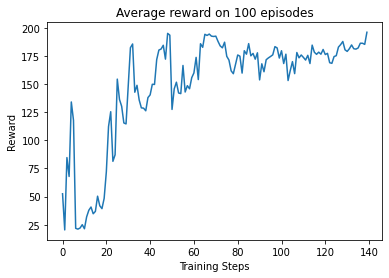

In [9]:
if __name__ == "__main__":

    #np.random.seed(1234)

    main()

    #state = np.array([0.1, 0.1, 0.1, 0.9])
    #theta = np.array([0.1, 0.9, 0.1, 0.9])
    #print(get_policy(state, theta))
    #print(type(get_policy(state, theta)))
#
    #action_list = [act_with_policy(state, theta) for _ in range(2000)]
    ##print(action_list)
    #plt.hist(action_list)
    #plt.show()
